## 1. Introduction

Object detection is the process of locating and classifying existing objects in an image.
Identified objects are shown with bounding boxes in the image. The purpose of this notebook is to use regression/classification-based method for objection detection

In [1]:
# import packages
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim import Adam
from torchvision.models import resnet50
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import cv2
import os
import imutils
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## 2. Declare some paths and hyper-parameters

In [2]:
# definie datasets paths
ANNOTATIONS_PATH = 'datasets/annotations/'
IMAGES_PATH = 'datasets/images/'
OUTPUT_PATH = 'output/'
TEST_PATH = 'output/test_paths.txt'

In [3]:
# define the device on which the model will be trained
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# specify the mean and standard deviation for transforms
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

In [5]:
# initialize some hyperparameters
LEARNING_RATE = 1e-4
EPOCHS = 20
BATCH_SIZE = 32

In [6]:
# Visualize some images
# For each class plot some images (4 per class here)
def plot_img(item_dir, top = 10):
    for dir_name in os.listdir(item_dir):
        item_files    = [os.path.join(item_dir+dir_name+'/', file) for file in os.listdir(item_dir+dir_name)][:4]
        plt.figure(figsize = (10, 10))
        for idx, img_path in enumerate(item_files):
            plt.subplot(5, 5, idx + 1)
            img = plt.imread(img_path)
            plt.title(dir_name)
            plt.tight_layout()         
            plt.imshow(img)

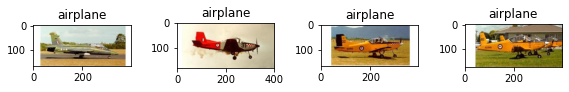

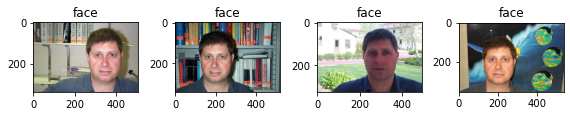

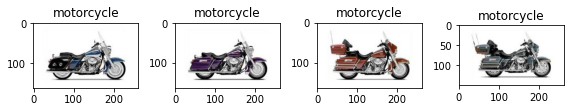

In [7]:
plot_img(IMAGES_PATH)

## 3. Create the custom dataset class
Pytorch provides the Dataset class from torch.utils.data to create custom
datasets for loading and processing data. We can do this by sub-classing the Dataset class
and overriding <code> __init__ </code>, the <code> __getitem__ </code> and functions <code> __len__ </code> . 

In [8]:
class CustomDetectorDataset(Dataset):
    def __init__(self, tensors, transforms=None):
        self.tensors = tensors
        self.transforms = transforms
    def __getitem__(self, index):
        # grab the image, label, and its bounding box coordinates
        image = self.tensors[0][index]
        label = self.tensors[1][index]
        bbox = self.tensors[2][index]
        # transpose the image such that its channel dimension becomes the leading one
        image = image.permute(2, 0, 1)
        # check to see if we have any image transformations to apply and if so, apply them
        if self.transforms:
            image = self.transforms(image)
        # return a tuple of the images, labels, and bounding box coordinates
        return (image, label, bbox)
    def __len__(self):
        # return the size of the dataset
        return self.tensors[0].size(0)

## 4. Build the model 

In [9]:
# building the object detection model
class ObjectDetectorModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(ObjectDetectorModel, self).__init__()
        # initialize the base model and the number of classes
        self.base_model = base_model
        self.num_classes = num_classes
        # build the regressor head to output the bounding box coordinates
        self.regressor = nn.Sequential(
            nn.Linear(base_model.fc.in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
            nn.Sigmoid()
        )
        # build the classifier head to predict the class labels
        self.classifier = nn.Sequential(
            nn.Linear(base_model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, self.num_classes)
        )
        # set the classifier of our base model to produce outputs from the last convolution block
        self.base_model.fc = nn.Identity()
    def forward(self, x):
        # pass the inputs through the base model and then obtain predictions from two different branches of the network
        features = self.base_model(x)
        bboxes = self.regressor(features)
        class_logits = self.classifier(features)
        # return the outputs as a tuple
        return (bboxes, class_logits)

## 5. Train the model
To train the model we prepare the images, labels, and bounding boxes in tensor and pass them through our custom dataset class. After that we define a function to train our model.

In [10]:
# read images,labels, and bounding boxes and store them into lists
data = []
labels = []
bboxes = []
image_paths = []

# loop over all CSV files in the annotations directory
for csv_path in paths.list_files(ANNOTATIONS_PATH, validExts=(".csv")):
    # load the contents of the current CSV annotations file
    rows = open(csv_path).read().strip().split("\n")
    # loop over the rows
    for row in rows:
        # break the row into the filename, bounding box coordinates, and class label
        row = row.split(",")
        (file_name, start_x, start_y, end_x, end_y, label) = row
        # derive the path to the input image, load the image (in OpenCV format), and grab its dimensions
        image_path = os.path.sep.join([IMAGES_PATH, label, file_name])
        image = cv2.imread(image_path)
        (height, width) = image.shape[:2]
        # rescale the bounding box coordinates dividing them by image height and width
        start_x = float(start_x) / width
        start_y = float(start_y) / height
        end_x = float(end_x) / width
        end_y = float(end_y) / height
        # change the image from BGR to RG and resize it
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        # update our list of data, class labels, bounding boxes, and image paths
        data.append(image)
        labels.append(label)
        bboxes.append((start_x, start_y, end_x, end_y))
        image_paths.append(image_path)

In [11]:
# convert the data, class labels, bounding boxes, and image paths to numpy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
image_paths = np.array(image_paths)
# perform label encoding on the labels
le = LabelEncoder()
labels = le.fit_transform(labels)

In [12]:
# partition the data into training and testing splits using 80% of the data for training and the remaining 20% for testing
split = train_test_split(data, labels, bboxes, image_paths,test_size=0.20, random_state=42)
# unpack the data split
(train_images, test_images) = split[:2]
(train_labels, test_labels) = split[2:4]
(train_bboxes, test_bboxes) = split[4:6]
(train_paths, test_paths) = split[6:]

In [13]:
# convert numpy arrays to PyTorch tensors
(train_images, test_images) = torch.tensor(train_images), torch.tensor(test_images)
(train_labels, test_labels) = torch.tensor(train_labels), torch.tensor(test_labels)
(train_bboxes, test_bboxes) = torch.tensor(train_bboxes), torch.tensor(test_bboxes)

In [14]:
# define normalization transforms
transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

In [15]:
# convert numpy arrays to PyTorch datasets
train_data = CustomDetectorDataset((train_images, train_labels, train_bboxes), transforms=transforms)
test_data = CustomDetectorDataset((test_images, test_labels, test_bboxes), transforms=transforms)
print("Total training samples: {} ".format(len(train_data)))
print("Total test samples: {} ".format(len(test_data)))


Total training samples: 1626 
Total test samples: 407 


In [16]:
# create data loaders
train_loader = DataLoader(train_data, 
                          batch_size=BATCH_SIZE,
                          shuffle=True
                         )
test_loader = DataLoader(test_data, 
                         batch_size=BATCH_SIZE
                        )

In [17]:
# Save the test image paths
f = open(TEST_PATH, "w")
f.write("\n".join(test_paths))
f.close()

In [18]:
# define the function to train de model
def train_model(model, optimizer, class_loss_func, bbox_loss_func, train_loader, test_loader, epochs=15, batch_size=32, device=DEVICE):
    # initialize the dict to store the history of the model
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    
    # calculate steps per epoch for training and validation set
    train_steps = len(train_loader.dataset) // batch_size
    val_steps = len(test_loader.dataset) // batch_size
    # specify the loss weights
    LABELS = 1.0
    BBOX = 1.0
    # loop over epochs
    for epoch in range(epochs):
        # set the model in training mode
        model.train()

        # initialize the training and validation loss
        train_loss = 0
        val_loss = 0

        # initialize the number of correct predictions in the training and validation step
        train_correct = 0
        val_correct = 0

        # loop over the training set
        for (images, labels, bboxes) in tqdm(train_loader):
            # send the input to the device
            (images, labels, bboxes) = (images.to(device),
            labels.to(device), bboxes.to(device))

            # perform a forward pass and calculate the training loss
            predictions = model(images)
            bbox_loss = bbox_loss_func(predictions[0], bboxes)
            class_loss = class_loss_func(predictions[1], labels)
            total_loss = (BBOX * bbox_loss) + (LABELS * class_loss)

            # zero out the gradients, perform the backpropagation step,and update the weights
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # add the loss to the total training loss so far and
            # calculate the number of correct predictions
            train_loss += total_loss
            train_correct += (predictions[1].argmax(1) == labels).type(torch.float).sum().item()

        # switch off autograd
        with torch.no_grad():
            # set the model in evaluation mode
            model.eval()
            # loop over the validation set
            for (images, labels, bboxes) in test_loader:
                # send the input to the device
                (images, labels, bboxes) = (images.to(device),labels.to(device), bboxes.to(device))
                # make the predictions and calculate the validation loss
                predictions = model(images)
                bbox_loss = bbox_loss_func(predictions[0], bboxes)
                class_loss = class_loss_func(predictions[1], labels)
                total_loss = (BBOX * bbox_loss) + (LABELS * class_loss)
                val_loss += total_loss
                # calculate the number of correct predictions
                val_correct += (predictions[1].argmax(1) == labels).type(torch.float).sum().item()

        # calculate the average training and validation loss
        avg_train_loss = train_loss / train_steps
        avg_val_loss = val_loss / val_steps

        # calculate the training and validation accuracy
        train_correct = train_correct / len(train_data)
        val_correct = val_correct / len(test_data)

        # update our training history
        history["train_loss"].append(avg_train_loss.cpu().detach().numpy())
        history["train_acc"].append(train_correct)
        history["val_loss"].append(avg_val_loss.cpu().detach().numpy())
        history["val_acc"].append(val_correct)

        # print the model training and validation information
        print("Epoch: {}/{}".format(epoch + 1, epochs))
        print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avg_train_loss, train_correct))
        print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(avg_val_loss, val_correct))
    return history

In [19]:
# define the function to save the model
def save_model(dir_path, file_name):
    torch.save(model, dir_path + file_name)

In [20]:
# define the function to save the label encoder to disk
def save_le(le_path, file_name):
    f = open(le_path + file_name, "wb")
    f.write(pickle.dumps(le))
    f.close()

In [21]:
# load the ResNet50 network
resnet = resnet50(pretrained=True)
# freeze all ResNet50 layers so that they will not be updated during the training process
for param in resnet.parameters():
    param.requires_grad = False

In [22]:
# create our custom object detector model and flash it to the current device
model = ObjectDetectorModel(resnet, len(le.classes_))
model = model.to(DEVICE)

In [23]:
# define our loss functions
# classification loss
class_loss_func = nn.CrossEntropyLoss()
# regression loss
bbox_loss_func = nn.MSELoss()

In [24]:
# initialize the optimizer, compile the model
opt = Adam(model.parameters(), lr=LEARNING_RATE)

In [25]:
# train and check the time of training
start_time = time.time()
history = train_model(model, opt, class_loss_func, bbox_loss_func, train_loader, test_loader, 15, BATCH_SIZE)
end_time = time.time()
print("*"*55)
print("The model took {:.2f} s for training : ".format(end_time - start_time))

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 1/15
Train loss: 0.806717, Train accuracy: 0.8112
Val loss: 0.239975, Val accuracy: 0.9975


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 2/15
Train loss: 0.156079, Train accuracy: 0.9828
Val loss: 0.034502, Val accuracy: 1.0000


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 3/15
Train loss: 0.061818, Train accuracy: 0.9865
Val loss: 0.042349, Val accuracy: 0.9926


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 4/15
Train loss: 0.041386, Train accuracy: 0.9932
Val loss: 0.015924, Val accuracy: 1.0000


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 5/15
Train loss: 0.033296, Train accuracy: 0.9938
Val loss: 0.009913, Val accuracy: 1.0000


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6/15
Train loss: 0.026449, Train accuracy: 0.9932
Val loss: 0.009208, Val accuracy: 1.0000


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 7/15
Train loss: 0.019311, Train accuracy: 0.9975
Val loss: 0.020252, Val accuracy: 0.9951


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8/15
Train loss: 0.017755, Train accuracy: 0.9963
Val loss: 0.006141, Val accuracy: 1.0000


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 9/15
Train loss: 0.020110, Train accuracy: 0.9969
Val loss: 0.004976, Val accuracy: 1.0000


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 10/15
Train loss: 0.020873, Train accuracy: 0.9951
Val loss: 0.006322, Val accuracy: 1.0000


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 11/15
Train loss: 0.021063, Train accuracy: 0.9951
Val loss: 0.004117, Val accuracy: 1.0000


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 12/15
Train loss: 0.013922, Train accuracy: 0.9975
Val loss: 0.009891, Val accuracy: 0.9975


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 13/15
Train loss: 0.007588, Train accuracy: 0.9975
Val loss: 0.003730, Val accuracy: 1.0000


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 14/15
Train loss: 0.007941, Train accuracy: 0.9988
Val loss: 0.003869, Val accuracy: 1.0000


100%|██████████| 51/51 [00:39<00:00,  1.28it/s]


Epoch: 15/15
Train loss: 0.007270, Train accuracy: 0.9988
Val loss: 0.005602, Val accuracy: 1.0000
*******************************************************
The model took 726.87 s for training : 


In [26]:
# save the model and the label encoder 
save_model(OUTPUT_PATH, "obj_detector.pth")
save_le(OUTPUT_PATH, "le.pickle")

## 6. Plot the model history

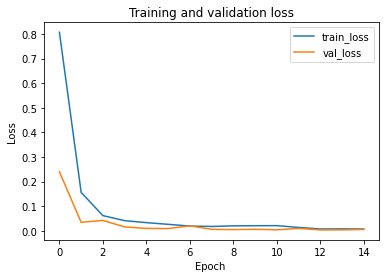

In [27]:
# plot the train and the val loss
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.title("Training and validation loss")
plt.xlabel("Epoch ")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

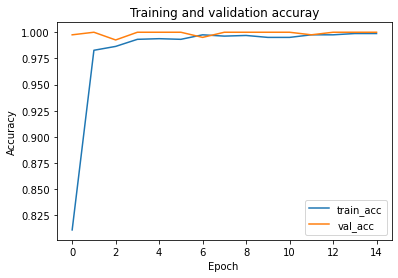

In [28]:
# plot the train and validation accuracy
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.title("Training and validation accuray")
plt.xlabel("Epoch ")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

In [29]:
# load our object detector model, set it evaluation mode, and label encoder from disk
model = torch.load(OUTPUT_PATH + "obj_detector.pth").to(DEVICE)
model.eval()
le = pickle.loads(open(OUTPUT_PATH + "le.pickle", "rb").read())

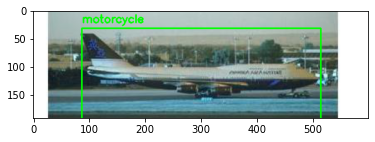

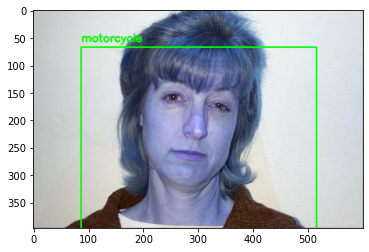

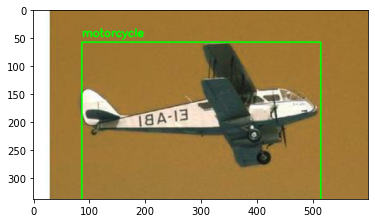

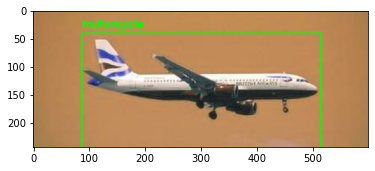

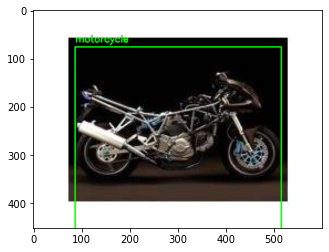

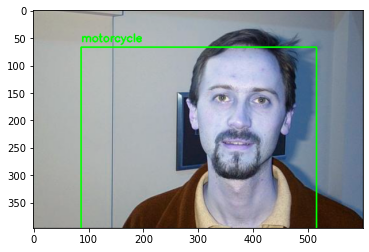

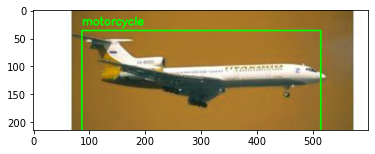

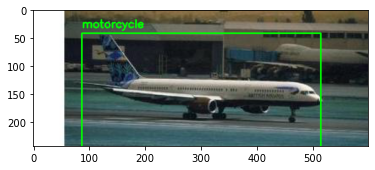

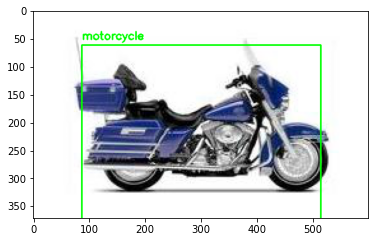

In [33]:
image_test_paths = open(TEST_PATH).read().strip().split("\n")
# loop over the images that want test using our bounding box regression model
image_test_paths = image_test_paths[:9]
for image_test_path in image_test_paths:
    # load the image, copy it, swap its colors channels, resize it, and bring its channel dimension forward
    image_test = cv2.imread(image_test_path)
    orig = image_test.copy()
    image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
    image_test = cv2.resize(image_test, (224, 224))
    image_test = image_test.transpose((2, 0, 1))
    # convert image to PyTorch tensor, normalize it, flash it to the current device, and add a batch dimension
    image_test = torch.from_numpy(image_test)
    image_test = transforms(image).to(DEVICE)
    image_test = image_test.unsqueeze(0)
    # predict the bounding box of the object along with the class label
    (box_preds, label_preds) = model(image_test)
    (start_x, start_y, end_x, end_y) = box_preds[0]
    # determine the class label with the largest predicted probability
    label_preds = torch.nn.Softmax(dim=-1)(label_preds)
    i = label_preds.argmax(dim = -1).cpu()
    label = le.inverse_transform(i)[0]
    # resize the original image such that it fits on our screen, and grab its dimensions
    orig = imutils.resize(orig, width=600)
    (h, w) = orig.shape[:2]
    # scale the predicted bounding box coordinates based on the image dimensions
    start_x = int(start_x * w)
    start_y = int(start_y * h)
    end_x = int(end_x * w)
    end_y = int(end_x * h)
    # draw the predicted bounding box and class label on the image
    y = start_y - 10 if start_y - 10 > 10 else start_y + 10
    cv2.putText(orig, label, (start_x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
    cv2.rectangle(orig, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
    # show the output image 
    plt.imshow(orig)
    plt.show()